# 04:  Metropolis Monte Carlo for Classical Systems

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
try: plt.style.use('./mc_notebook.mplstyle')
except: pass

## Evaluating Phase Space Integrals

We have seen that Monte Carlo methods are an ideal way to sample high-dimensional integrals.  We now ask if this can be applied to the phase space integrals that appear when computing equilbrium observables in classical statistical mechanics for $N$ interacting particles.  

Starting with the Hamiltonian:

\begin{equation}
H = -\frac{\hbar^2}{2m} \sum_{i=1}^{N} \nabla_i^2 + \frac{1}{2}\sum_{i,j} V_{ij}
\end{equation}

we are interested in the expectation value of some observable $\mathcal{O}$:

\begin{equation}
\langle \mathcal{O} \rangle = \frac{1}{\mathcal{Z}} \int d^{d} x_1 \cdots \int d^{d} x_N\, \mathcal{O}(\mathbf{x}) \mathrm{e}^{-\beta V(\mathbf{x})}
\end{equation}

where the partition function is given by ($\beta = (k_{\rm B} T)^{-1}$):

\begin{equation}
\mathcal{Z} = \int d^{d} x_1 \cdots \int d^{d} x_N\,  \mathrm{e}^{-\beta V(\mathbf{x})}.
\end{equation}

Thus we we can immediatly identify this with our previous importance sampling scheme:

\begin{equation}
\langle \mathcal{O} \rangle = \int d^{d} x_1 \cdots \int d^{d} x_N\, \mathcal{O}(\mathbf{x}) \pi( \mathbf{x}) \simeq \frac{1}{M} \sum_m \mathcal{O}(\mathbf{x}_m)
\end{equation}

where 

\begin{equation}
\pi(\mathbf{x}) = \frac{\mathrm{e}^{-\beta V(\mathbf{x})}}{\mathcal{Z}}
\end{equation}

is the Boltzmann weight. 

### Key Problem: 

How do we effeciently sample the correct Boltzmann probability distribution?


Solved by:

N. Metropolis, A. W. Rosenbluth, M. N. Rosenbluth, A. H. Teller, and E. Teller, *Equation of State Calculations by Fast Computing Machines*, J. Chem. Phys. **21**, 1087 (1953).

https://aip.scitation.org/doi/abs/10.1063/1.1699114

<img src='./metropolis.png', width=600px>

## Markov Chain Monte Carlo

Since $\pi(\mathbf{x})$ is an extremely complicated $dN$-dimensional probability distribution there is no hope of direct sampling.  However, we can recall our strategy to the *pebble throwing game* when we imagined that the entire area couldn't be reached with a single toss: **Markov chain sampling**.

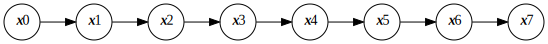

In [36]:
from IPython.display import display

try:
    import graphviz
    markov_chain = graphviz.Digraph()
    markov_chain.attr(rankdir='LR')
    for i in range(2**3):
        markov_chain.node(name="x%d"%i, label="<<i><b>x</b></i><sub>%d</sub>>"%i, shape='circle')

    for i in range(2**3-1):
        markov_chain.edge("x%d"%i, "x%d"%(i+1)) 
                          
    display(markov_chain)
    
except:
    pass

The goal is to build a Markov Chain consisting of a sequence of valid configuraitons $\mathbf{x}_n$ such that $\pi(\mathbf{x}_n)$ reflects the stationary probability of the system being in configuraiotn $\mathbf{x}_n$.

We achieve this via a set of *transition probabilities* $p_{n,m} = p(\mathbf{x}_n \to \mathbf{x}_{m})$ which encode the liklihood of moving from configuration $\mathbf{x}_n \to \mathbf{x}_{m}$.  We require:

### 1. Normalization

\begin{equation}
\sum_{m} p_{n,m} = 1
\end{equation}

### 2. Detailed Balance

The probability of configuration $\mathbf{x}_n$, $\pi_n \equiv \pi(\mathbf{x}_n)$, is generated via all possible ways of obtaining it:

\begin{align}
\pi_n &= \sum_{m} \pi_{m} p_{m,n}\\
\pi_n(1-p_{n,n}) &= \sum_{m\ne n} \pi_{m} p_{m,n} .
\end{align}

Now utilizing the normalization condition:
\begin{equation}
\sum_{m} p_{n,m} = 1 \Rightarrow 1-p_{nn} = \sum_{m\ne n} p_{n,m}
\end{equation}

above we can write:

\begin{equation}
\pi_n \sum_{m \ne n} p_{n,m} = \sum_{m\ne n} \pi_{m} p_{m,n}.
\end{equation}

One obvious solution to this equation which is sufficient but not necessary is to equate each term individually (this is *detailed balance*):

\begin{equation}
\boxed{\pi_n  p_{n,m} = \pi_{m} p_{m,n}}.
\end{equation}

### 3. Ergodicity

Any configuraiton is reachable from any other, i.e. $\forall m,n,\ \exists a \, : (p^a)_{m,n} \ne 0$. The graph corresponding to the Markov chain is connected.


## Metropolis Algorithm

Teller's solution to generating a Markov Chain satisfying these conditions was to use the rejection sampling scheme we have already employed in combination with choosing the probability to move from configuration $\mathbf{x}_n \to \mathbf{x}_m$ to be composite:

\begin{equation}
\mathcal{P}(\mathbf{x}_n \to \mathbf{x}_m) = \mathcal{A}(\mathbf{x}_n \to \mathbf{x}_m) p(\mathbf{x}_n \to \mathbf{x}_m)
\end{equation}

where $\mathcal{A}(\mathbf{x}_n \to \mathbf{x}_m)$ is an *a priori* proposal probability and $p(\mathbf{x}_n \to \mathbf{x}_m)$ is the acceptance probability.

Our *detailed balance* condition requires:

\begin{equation}
\pi(\mathbf{x}_n) \mathcal{P}(\mathbf{x}_n \to \mathbf{x}_m) =\pi(\mathbf{x}_m) \mathcal{P}(\mathbf{x}_m \to \mathbf{x}_n) 
\end{equation}

\begin{equation}
\frac{p(\mathbf{x}_n \to \mathbf{x}_m)}{p(\mathbf{x}_m \to \mathbf{x}_n)} = \frac{\pi(\mathbf{x}_m)\mathcal{A}(\mathbf{x}_m \to \mathbf{x}_n)}{\pi(\mathbf{x}_n)\mathcal{A}(\mathbf{x}_n \to \mathbf{x}_m)}
\end{equation}

which is satified by the choice:

\begin{equation}
p(\mathbf{x}_n \to \mathbf{x}_m) = \text{min}\left[1,\frac{\pi(\mathbf{x}_m)\mathcal{A}(\mathbf{x}_m \to \mathbf{x}_n)}{\pi(\mathbf{x}_n)\mathcal{A}(\mathbf{x}_n \to \mathbf{x}_m)}\right].
\end{equation}

The idea is to :

1. Starting from configuration $\mathbf{x}_n$.
2. Propose some change to the configuration with *a priori* proposal probability $\mathcal{A}(\mathbf{x}_n \to \mathbf{x}_m)$.
3. Accept the change with probability $p(\mathbf{x}_n \to \mathbf{x}_m)$ given by the expression above where $\pi(\mathbf{x})$ is known (i.e. the Boltzmann weight) and $\mathcal{A}(\mathbf{x}_n \to \mathbf{x}_m)$ can be chosen.

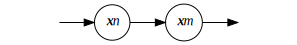

In [46]:
try:
    markov_chain_snippet = graphviz.Digraph()
    markov_chain_snippet.attr(rankdir='LR')

    markov_chain_snippet.node(name="x%d"%0, label="⋯", shape='none')
    markov_chain_snippet.node(name="x%d"%1, label="<<i><b>x</b></i><sub><i>n</i></sub>>", shape='circle')
    markov_chain_snippet.node(name="x%d"%2, label="<<i><b>x</b></i><sub><i>m</i></sub>>", shape='circle')
    markov_chain_snippet.node(name="x%d"%3, label="⋯", shape='none')

    for i in range(3):
        markov_chain_snippet.edge("x%d"%i, "x%d"%(i+1)) 

    display(markov_chain_snippet)
except:
    pass

### How do we sample the $p$ distribution?

For a given configuration $\mathbf{x}_n$, some update scheme that changes to configuration $\mathbf{x}_m$, and known functions $\pi$ and $\mathcal{A}$ we can sample $p$ via rejection:

1. Compute $p$ as a real number using the formula above.
2. Generate a uniform random number $r \in \mathcal{U}_{[0,1)}$
3. If $r < p$ accept the configuration change to $\mathbf{x}_m$; otherwise reject and return to configuration $\mathrm{x}_n$.

#### Let's test this approach for the 2D classical Ising Model!